In [1]:
import pygame
from pygame.math import Vector2
import random
import time
import math
import numpy as np
import matplotlib.pyplot as plt

pygame 2.6.1 (SDL 2.28.4, Python 3.12.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


- Frist, we define the Ant

In [3]:
# Ant class
class Ant:
    def __init__(self, x, y, speed, olfaction):
        self.x = x
        self.y = y
        self.speed = speed
        self.olfaction = olfaction
        self.carrying_sugar = False
        self.scent_trail = None
        angle = random.uniform(0, 2 * math.pi)
        self.direction = Vector2(math.cos(angle), math.sin(angle))
        self.id = id(self)

    def leave_scent(self):
        self.scent_trail = {
            'x': self.x,
            'y': self.y,
            'time': time.time(),
            'intensity': INITIAL_PHEROMONE_INTENSITY,  # Initial intensity
            'ant_id': self.id,
            'direction': self.direction.copy()
            }

    def update(self, all_scents, scents_to_remove):
        if not self.carrying_sugar:
            self.check_scent_overlap(all_scents, scents_to_remove)
        self.move()
        self.check_sugar()
        self.check_nest()

    def move(self):
        # Update position
        self.x += self.direction.x * self.speed
        self.y += self.direction.y * self.speed

        # Reflect at borders
        if self.x <= 0 or self.x >= WINDOW_WIDTH:
            self.direction.x *= -1
            self.x = max(0, min(self.x, WINDOW_WIDTH))
        if self.y <= 0 or self.y >= WINDOW_HEIGHT:
            self.direction.y *= -1
            self.y = max(0, min(self.y, WINDOW_HEIGHT))

        # Leave scent trail only if carrying sugar
        if self.carrying_sugar:
            self.leave_scent()

    def check_scent_overlap(self, all_scents, scents_to_remove):
        ant_pos = Vector2(self.x, self.y)
        for scent in all_scents:
            scent_pos = Vector2(scent['x'], scent['y'])
            if ant_pos.distance_to(scent_pos) < 5:
                if scent['ant_id'] != self.id:
                    # Remove the scent trail point
                    scents_to_remove.append(scent)
                    # Set ant's direction to opposite of scent's direction
                    self.direction = -scent['direction']
                    if self.direction.length() == 0:
                        # Assign a random direction if zero length
                        angle = random.uniform(0, 2 * math.pi)
                        self.direction = Vector2(math.cos(angle), math.sin(angle))
                    else:
                        self.direction = self.direction.normalize()
                    return  # Only process one scent at a time

        # If not carrying sugar and no scent encountered, move randomly
        self.random_move()

    def random_move(self):
        # Slightly adjust the current direction
        angle_change = random.uniform(-0.3, 0.3)
        current_angle = math.atan2(self.direction.y, self.direction.x)
        new_angle = current_angle + angle_change
        self.direction = Vector2(math.cos(new_angle), math.sin(new_angle))
        # Ensure direction is normalized
        if self.direction.length() == 0:
            angle = random.uniform(0, 2 * math.pi)
            self.direction = Vector2(math.cos(angle), math.sin(angle))

    def check_sugar(self):
        if not self.carrying_sugar:
            ant_pos = Vector2(self.x, self.y)
            for sugar in sugar_piles:
                sugar_pos = Vector2(sugar.x, sugar.y)
                if ant_pos.distance_to(sugar_pos) < SUGAR_RADIUS:
                    self.carrying_sugar = True
                    sugar.capacity -= 1  # Reduce sugar capacity
                    # Move towards nest
                    nest_pos = Vector2(NEST_POSITION)
                    self.direction = (nest_pos - ant_pos).normalize()
                    if sugar.is_depleted():
                        sugar_piles.remove(sugar)  # Remove depleted pile
                    break


    def check_nest(self):
        if self.carrying_sugar:
            ant_pos = Vector2(self.x, self.y)
            nest_pos = Vector2(NEST_POSITION)
            if ant_pos.distance_to(nest_pos) < NEST_RADIUS:
                self.carrying_sugar = False  # Drop off sugar at the nest
                # Reset scent_trail after dropping off sugar
                self.scent_trail = None
                # After dropping sugar, pick a random direction
                angle = random.uniform(0, 2 * math.pi)
                self.direction = Vector2(math.cos(angle), math.sin(angle))

    def draw(self):
        # Base size for the triangle
        size = 10
    
        # Calculate the direction vector for orientation
        forward = self.direction.normalize() * size
        right = forward.rotate(120) * 0.5  # Rotate for the right corner
        left = forward.rotate(-120) * 0.5  # Rotate for the left corner
    
        # Define the triangle vertices
        center = Vector2(self.x, self.y)
        point1 = center + forward  # Tip of the triangle
        point2 = center + right    # Bottom-right corner
        point3 = center + left     # Bottom-left corner
    
        # Choose color based on carrying sugar
        ant_color = ANT_COLOR if not self.carrying_sugar else ANT_CARRYING_COLOR
    
        # Draw the triangle
        pygame.draw.polygon(screen, ant_color, [(point1.x, point1.y), (point2.x, point2.y), (point3.x, point3.y)])

- Then the class Sugar (food)

In [6]:
class SugarPile:
    def __init__(self, x, y, capacity=25):
        self.x = x
        self.y = y
        self.capacity = capacity  # Amount of sugar in the pile

    def draw(self):
        pygame.draw.circle(screen, SUGAR_COLOR, (int(self.x), int(self.y)), SUGAR_RADIUS)
        font = pygame.font.SysFont(None, 18)
        text = font.render(str(self.capacity), True, BLACK)
        screen.blit(text, (self.x - 10, self.y - 10))

    def is_depleted(self):
        return self.capacity <= 0

- And the Nest

In [10]:
# Nest class
class Nest:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def draw(self):
        pygame.draw.circle(screen, NEST_COLOR, (int(self.x), int(self.y)), NEST_RADIUS)

- The function to set up the initial simulation

In [13]:
def reset_simulation():
    """Reset the simulation to its initial state."""

    # Initialize ants
    ants = [
        Ant(
            random.randint(NEST_POSITION[0] - 10, NEST_POSITION[0] + 10),
            random.randint(NEST_POSITION[1] - 10, NEST_POSITION[1] + 10),
            ANT_SPEED,
            OLFACTION_RADIUS
        )
        for _ in range(NUM_ANTS)
    ]

    # Initialize sugar piles
    sugar_piles = []
    while len(sugar_piles) < NUM_SUGAR_PILES:
        x = random.randint(50, WINDOW_WIDTH - 50)
        y = random.randint(50, WINDOW_HEIGHT - 50)
        if Vector2(x, y).distance_to(Vector2(NEST_POSITION)) > NEST_RADIUS + 100:
            sugar_piles.append(SugarPile(x, y))
    all_scents = []  # Clear all pheromone trails

    # Initialize nest
    nest = Nest(*NEST_POSITION)

    return ants, sugar_piles, nest, all_scents

- Setting up parameters

In [16]:
# Initialize lists to store aggregated results
time_steps_all = []
ants_carrying_sugar_all = []
pheromone_intensity_all = []
sugar_depletion_all = []

# Colors
BLACK = (0, 0, 0)
WHITE = (255, 255, 255)
ANT_COLOR = BLACK
ANT_CARRYING_COLOR = (255, 0, 0)  # Red when carrying sugar
SCENT_COLOR = (170, 160, 160)
SUGAR_COLOR = (255, 215, 0)  # Gold for sugar
NEST_COLOR = (139, 69, 19)  # Brown for nest

# Set display window
WINDOW_WIDTH = 1300
WINDOW_HEIGHT = 750

# Set FPS and Clock
FPS = 120
clock = pygame.time.Clock()

# Ant parameters
NUM_ANTS = 50 # Number of ants
ANT_SPEED = 2.5
OLFACTION_RADIUS = 75

# Pheromone parameters
PHEROMONE_DECAY_RATE = 0.01  # Rate at which pheromone intensity decays
INITIAL_PHEROMONE_INTENSITY = 1.0  # Starting intensity for a new pheromone

# Sugar parameters
NUM_SUGAR_PILES = 20 # Number of sugar piles
SUGAR_RADIUS = 20

# Nest parameters
NEST_POSITION = (WINDOW_WIDTH // 2, WINDOW_HEIGHT // 2)
NEST_RADIUS = 40

# Main game loop
running = 2000 # Number of steps
paused = False  # Pause flag

# Number of Monte Carlo simulations
NUM_SIMULATIONS = 100

# Initialize lists to store aggregated results
time_steps_all = []
ants_carrying_sugar_all = []
pheromone_intensity_all = []
sugar_depletion_all = []

- Run the Monte Carlo simulation

In [19]:
# Initialize pygame
pygame.init()

# Set display window
size = (WINDOW_WIDTH, WINDOW_HEIGHT)
screen = pygame.display.set_mode(size)

for seed in range(NUM_SIMULATIONS):

    # Initialize metrics
    time_steps = []
    ants_carrying_sugar = []
    pheromone_intensity = []
    sugar_depletion = []

    # Begin the simulation
    ants, sugar_piles, nest, all_scents = reset_simulation()
    pygame.display.set_caption("Ant Simulation - " + str(seed+1))
    
    for step in range(running):
        
        clock.tick(FPS)
        
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_p:  # Toggle pause
                    paused = not paused
                # elif event.key == pygame.K_r:  # Restart the simulation
                #     reset_simulation()
                    
        if not paused:
            # Update simulation
            screen.fill(WHITE)
            scents_to_remove = []
    
            # Track metrics
            time_steps.append(pygame.time.get_ticks() / 1000)  # Time in seconds
    
            # Count ants carrying sugar
            ants_carrying_sugar.append(sum(1 for ant in ants if ant.carrying_sugar))
    
            # Sum total pheromone intensity
            pheromone_intensity.append(sum(scent['intensity'] for scent in all_scents))
    
            # Calculate remaining sugar
            sugar_depletion.append(sum(sugar.capacity for sugar in sugar_piles))
    
            # Update and draw ants
            for ant in ants:
                ant.update(all_scents, scents_to_remove)
                ant.draw()
                if ant.scent_trail is not None:
                    all_scents.append(ant.scent_trail)
    
            # Decay pheromones
            updated_scents = []
            for scent in all_scents:
                if 'intensity' not in scent:
                    scent['intensity'] = INITIAL_PHEROMONE_INTENSITY
                scent['intensity'] -= PHEROMONE_DECAY_RATE
                if scent['intensity'] > 0:
                    updated_scents.append(scent)
    
            all_scents = updated_scents
    
            # Draw pheromone trails
            for scent in all_scents:
                intensity_color = max(0, min(255, int(scent['intensity'] * 255)))
                scent_color = (intensity_color, intensity_color, intensity_color)
                pygame.draw.circle(screen, scent_color, (int(scent['x']), int(scent['y'])), 2)
    
            # Draw sugar piles
            for sugar in sugar_piles:
                sugar.draw()
    
            # Draw nest
            nest.draw()
            
            pygame.display.flip()
            
        # else:
        #     # Show "Paused" message on the screen
        #     screen.fill(WHITE)
        #     font = pygame.font.SysFont(None, 50)
        #     text = font.render("PAUSED - Press P to Resume", True, BLACK)
        #     screen.blit(text, (WINDOW_WIDTH // 2 - 250, WINDOW_HEIGHT // 2 - 25))
        #     pygame.display.flip()

        time_steps_all.append(time_steps)
        ants_carrying_sugar_all.append(ants_carrying_sugar)
        pheromone_intensity_all.append(pheromone_intensity)
        sugar_depletion_all.append(sugar_depletion)

pygame.quit()

- Plot the results

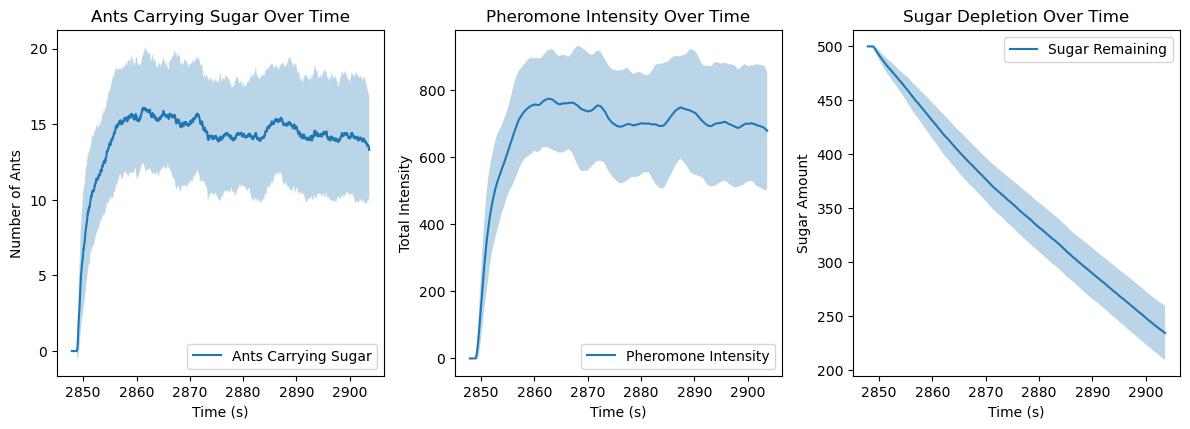

In [21]:
# Convert lists into numpy arrays for statistical analysis
time_steps_all = np.array(time_steps_all)
ants_carrying_sugar_all = np.array(ants_carrying_sugar_all)
pheromone_intensity_all = np.array(pheromone_intensity_all)
sugar_depletion_all = np.array(sugar_depletion_all)

# Compute mean and standard deviation for each metric
mean_ants_carrying_sugar = np.mean(ants_carrying_sugar_all, axis=0)
std_ants_carrying_sugar = np.std(ants_carrying_sugar_all, axis=0)

mean_pheromone_intensity = np.mean(pheromone_intensity_all, axis=0)
std_pheromone_intensity = np.std(pheromone_intensity_all, axis=0)

mean_sugar_depletion = np.mean(sugar_depletion_all, axis=0)
std_sugar_depletion = np.std(sugar_depletion_all, axis=0)

# Plot the aggregated results with error bars (standard deviation)
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.plot(np.mean(time_steps_all, axis=0), mean_ants_carrying_sugar, label="Ants Carrying Sugar")
plt.fill_between(np.mean(time_steps_all, axis=0), 
                 mean_ants_carrying_sugar - std_ants_carrying_sugar, 
                 mean_ants_carrying_sugar + std_ants_carrying_sugar, alpha=0.3)
plt.xlabel("Time (s)")
plt.ylabel("Number of Ants")
plt.title("Ants Carrying Sugar Over Time")
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(np.mean(time_steps_all, axis=0), mean_pheromone_intensity, label="Pheromone Intensity")
plt.fill_between(np.mean(time_steps_all, axis=0), 
                 mean_pheromone_intensity - std_pheromone_intensity, 
                 mean_pheromone_intensity + std_pheromone_intensity, alpha=0.3)
plt.xlabel("Time (s)")
plt.ylabel("Total Intensity")
plt.title("Pheromone Intensity Over Time")
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(np.mean(time_steps_all, axis=0), mean_sugar_depletion, label="Sugar Remaining")
plt.fill_between(np.mean(time_steps_all, axis=0), 
                 mean_sugar_depletion - std_sugar_depletion, 
                 mean_sugar_depletion + std_sugar_depletion, alpha=0.3)
plt.xlabel("Time (s)")
plt.ylabel("Sugar Amount")
plt.title("Sugar Depletion Over Time")
plt.legend()

plt.tight_layout()
plt.show()